In [2]:
import os,sys,signal
import math

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
sys.path.insert(0, '../')

import musicnet

from time import time

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='2'

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn

import tp

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = "cpu"

ModuleNotFoundError: No module named 'tp'

In [2]:
# Network Parameters
train_size = 100000
test_size = 50000
epsilon = 1e-5
fs = 44100

lr = 1e-6
momentum = .95

pitch_shift = 0
jitter = 0.
num_workers = 10
sequence = 1

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100
freq_bins = 2049

regions = 1 + (window)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': num_workers, 'pin_memory': True, 'worker_init_fn': worker_init}

In [3]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [4]:
result_dict = {'loss_history_train': [],
               'avgp_history_train': [],
               'loss_history_test': [],
               'avgp_history_test': [],
               "Mir_Eval": [],
               'parameters': {}}

result_dict['parameters']['train_size'] = train_size
result_dict['parameters']['test_size'] = test_size
result_dict['parameters']['lr'] = lr
result_dict['parameters']['pitch_shift'] = pitch_shift
result_dict['parameters']['jitter'] = jitter
result_dict['parameters']['window'] = window

# Preparing Dataset

In [5]:
start = time()
root = './data/'
train_set = musicnet.MusicNet(root=root, epoch_size=train_size,sequence=sequence
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root, train=False, download=True,sequence=sequence
                             , refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Data loaded, time used = {:2.2f} seconds".format(time()-start))

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

Data loaded, time used = 28.36 seconds


# Defining Models

In [6]:
Loss = torch.nn.BCELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [7]:
n_mels=1024
htk=True
center=True
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        # Getting Mel Spectrogram on the fly
        self.mel_layer = Spectrogram.MelSpectrogram(sr=fs, n_fft=n_fft, n_mels=n_mels, htk=htk, fmin=50, fmax=6000, center=center, trainable_mel=False)
            
        # Creating Layers
        self.linear = torch.nn.Linear(n_mels*regions, m, bias=False)
        torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
        self.avg = avg
        
    def forward(self,x):
        z = self.mel_layer(x)
        z = torch.relu(z)
        y = self.linear((torch.log(z+epsilon)).view(x.data.size()[0],n_mels*regions))
        return torch.sigmoid(y)
    

In [8]:
model = Model()
model.to(device)

/workspace/public_data/raven/ICASSP2020/Spectrogram.py:578: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


Model(
  (mel_layer): MelSpectrogram()
  (linear): Linear(in_features=33792, out_features=128, bias=False)
)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 35
try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"training {i}/{len(train_loader)} batches", end = '\r')
                optimizer.zero_grad()

                # making x and y into pytorch dealable format
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data

                optimizer.step()
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())  

            result_dict['loss_history_train'].append(loss_e/len(train_loader))
            result_dict['avgp_history_train'].append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight

            # For testing
            yground = torch.Tensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(test_loader), m)

            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            result_dict['loss_history_test'].append(loss_e/len(test_loader))
            result_dict['avgp_history_test'].append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         result_dict['loss_history_train'][-1],result_dict['loss_history_test'][-1],
                         result_dict['avgp_history_train'][-1],result_dict['avgp_history_test'][-1],
                         time()-t, time()-t1))

except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")

epoch	train loss	test loss	train avg	test avg	time	utime
0	5.046527	3.426358	0.204624	0.432643	126.0	40.2
1	3.813747	2.854614	0.509571	0.513225	126.0	40.0
2	3.361868	2.622244	0.560346	0.550316	125.6	40.6
3	3.152200	2.473923	0.589096	0.571610	126.1	40.5
4	3.034464	2.404543	0.605886	0.583332	124.8	40.5
5	2.950832	2.347562	0.619306	0.600089	125.7	40.6
6	2.896505	2.310350	0.626848	0.604606	126.6	40.9
7	2.845218	2.250624	0.636156	0.618264	126.5	40.7
8	2.816717	2.228036	0.641739	0.622007	125.7	40.5
9	2.791557	2.208391	0.642977	0.628357	125.3	40.6
10	2.782295	2.199435	0.646430	0.632072	126.4	40.5
11	2.760400	2.168173	0.649868	0.636648	126.3	40.7
Graceful Exit1000 batches


In [13]:
model.mel_layer = Spectrogram.MelSpectrogram(sr=fs, n_fft=n_fft, n_mels=n_mels, htk=htk, fmin=50, fmax=6000, center=center, trainable_mel=True)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 35
try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"training {i}/{len(train_loader)} batches", end = '\r')
                optimizer.zero_grad()

                # making x and y into pytorch dealable format
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data

                optimizer.step()
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())  

            result_dict['loss_history_train'].append(loss_e/len(train_loader))
            result_dict['avgp_history_train'].append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight

            # For testing
            yground = torch.Tensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(test_loader), m)

            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            result_dict['loss_history_test'].append(loss_e/len(test_loader))
            result_dict['avgp_history_test'].append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         result_dict['loss_history_train'][-1],result_dict['loss_history_test'][-1],
                         result_dict['avgp_history_train'][-1],result_dict['avgp_history_test'][-1],
                         time()-t, time()-t1))

except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")

epoch	train loss	test loss	train avg	test avg	time	utime
0	2.600988	2.097811	0.680068	0.660468	134.6	40.7
1	2.571981	2.094215	0.683089	0.659492	134.3	40.6
2	2.527469	2.075081	0.690801	0.661859	133.3	40.7
3	2.515940	2.046237	0.693066	0.669303	133.7	40.5
4	2.509748	2.048616	0.694715	0.666293	134.1	40.7
5	2.498005	2.043643	0.696375	0.672975	133.8	40.6
6	2.489267	2.053690	0.697824	0.667427	133.2	40.2
7	2.487893	2.033627	0.700363	0.673408	132.5	40.7
8	2.490052	2.040657	0.698489	0.676443	133.7	40.9
9	2.473646	2.013848	0.700644	0.679649	134.6	40.4
10	2.462775	2.031345	0.702213	0.674480	134.9	40.6
11	2.456518	2.057388	0.704515	0.670516	133.4	39.5
12	2.444676	2.040432	0.707598	0.672726	134.1	39.9
13	2.440036	2.015620	0.707663	0.674608	134.5	40.6
14	2.441463	2.017350	0.708049	0.682218	134.2	40.5
15	2.426665	2.029547	0.709868	0.678253	133.2	40.2
16	2.423350	2.034943	0.710561	0.675934	132.9	39.2
17	2.417891	2.001416	0.710667	0.680752	133.5	39.8
18	2.407763	2.003435	0.713648	0.678817	134.0	40.6
19	

In [16]:
mel_basis = model.mel_layer.mel_basis.cpu().detach().numpy()

In [17]:
mel_basis.shape

(1024, 2049)

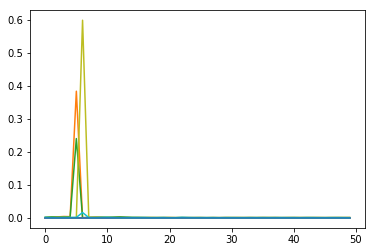

In [23]:
counter = 0
for i in mel_basis:
    plt.plot(i[:50])
    if counter == 10:
        break
    counter +=1

In [25]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
Accavg = 0
Etotavg = 0
model.eval()
for songid in test_set.rec_ids:
    Y_pred, Y_true = musicnet.get_piano_roll(songid, test_set, model, device,
                                             window=window, m=m, stride=-1)
    _,_,_,Acc,Etot = musicnet.get_mir_accuracy(Y_pred, Y_true, m=m)
    Accavg += Acc
    Etotavg += Etot
    result_dict['Mir_Eval'].append([Acc, Etot])

print('Average Accuracy: \t{:2.2f}\nAverage Error: \t\t{:2.2f}'
      .format(Accavg/len(test_set.rec_ids)*100, Etotavg/len(test_set.rec_ids)*100))


AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
75.24	73.17	70.82	0.56	0.43	0.12	0.17	0.14        
76.54	72.77	71.98	0.57	0.46	0.09	0.19	0.18        
44.64	53.62	41.12	0.30	0.77	0.18	0.41	0.18        
63.80	58.11	71.71	0.47	0.70	0.10	0.19	0.42        
75.87	65.93	82.25	0.58	0.46	0.14	0.04	0.29        
72.50	65.96	70.87	0.52	0.51	0.15	0.14	0.22        
66.58	69.20	57.57	0.46	0.53	0.15	0.28	0.11        
67.23	66.36	61.77	0.47	0.55	0.15	0.24	0.17        
75.33	72.85	68.28	0.54	0.47	0.10	0.22	0.15        
69.94	67.27	71.05	0.53	0.51	0.13	0.16	0.22        
Average Accuracy: 	50.02
Average Error: 		53.89
